# 指静脉识别

## 导入数据集

### 导入包

In [1]:
import mxnet as mx
from mxnet import ndarray as nd
from mxnet import autograd as ag
from mxnet import gluon
from mxnet.gluon.data import vision
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.data import DataLoader
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon import nn
from mxnet import init
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from scipy import misc
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [4]:
transform_train = transforms.Compose([
#     transforms.RandomFlipLeftRight(),
#     transforms.RandomFlipTopBottom(),
#     transforms.RandomBrightness(0.1), 
#     transforms.RandomContrast(0.1), 
    transforms.Resize(224), 
    transforms.ToTensor()
])

transform_valid = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

In [5]:
# pretrained
data_dir = './data/FV_TJ_all/'
batch_size = 8

train_ds = vision.ImageFolderDataset(root=data_dir, flag=1)

train_data = DataLoader(train_ds.transform_first(transform_train), 
                        batch_size, shuffle=True, last_batch='keep')

In [ ]:
# transforms.RandomContrast??

In [6]:
data_dir = './data/FV_TJ/'
batch_size = 8

train_ds = vision.ImageFolderDataset(root=data_dir+'train', flag=1)
valid_ds = vision.ImageFolderDataset(root=data_dir+'valid', flag=1)

train_data = DataLoader(train_ds.transform_first(transform_train), 
                        batch_size, shuffle=True, last_batch='keep')
valid_data = DataLoader(valid_ds.transform_first(transform_valid), 
                        batch_size, shuffle=False, last_batch='keep')

In [7]:
print(len(train_ds))

print(len(train_data))
for data, label in train_data:
    print(data.shape, label.shape)
    print(label.as_in_context(mx.gpu(0)))
    break

320
40
(8, 3, 224, 224) (8,)

[11 44 49  4 27 56 33 49]
<NDArray 8 @gpu(0)>


## softmax loss

In [2]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## center loss

In [3]:
class CenterLoss(gluon.HybridBlock):
    r"""
    Center Loss: A Discriminative Feature Learning Approach for Deep Face Recognition
    """
    def __init__(self, num_classes, feature_size, lmbd, **kwargs):
        super(CenterLoss, self).__init__(**kwargs)
        self._num_classes = num_classes
        self._feature_size = feature_size
        self._lmda = lmbd
        self.centers = self.params.get('centers', shape=(num_classes, feature_size))

    def hybrid_forward(self, F, feature, label, centers):
        hist = F.array(np.bincount(label.asnumpy().astype(int)))
        centers_count = F.take(hist, label)
        centers_selected = F.take(centers, label)
        diff = feature - centers_selected
        loss = self._lmda * 0.5 * F.sum(F.square(diff), 1) / centers_count
        return F.mean(loss, axis=0, exclude=True)

In [4]:
center_loss = CenterLoss(num_classes=64, feature_size=1792, lmbd=0.2) #lmbd = 0.2 99.4595

## triplet loss

In [11]:
# triplet_loss = gluon.loss.TripletLoss()

In [12]:
# gluon.loss.TripletLoss??

## 定义模型 --FingerveinNet

In [5]:
class block_35(nn.HybridBlock):
    def __init__(self, channels, **kwargs):
        super(block_35, self).__init__(**kwargs)
        with self.name_scope():
            branch_1 = nn.HybridSequential()
            branch_1.add(nn.Conv2D(channels=channels[0], kernel_size=1, 
                                   strides=1, padding=0))
            branch_1.add(nn.BatchNorm())
            branch_1.add(nn.Activation(activation='relu'))
            
            branch_2 = nn.HybridSequential()
            branch_2.add(nn.Conv2D(channels=channels[1], kernel_size=1, 
                                   strides=1, padding=0))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[2], kernel_size=3, 
                                   strides=1, padding=1))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            
            branch_3 = nn.HybridSequential()
            branch_3.add(nn.Conv2D(channels=channels[3], kernel_size=1, 
                                   strides=1, padding=0))
            branch_3.add(nn.BatchNorm())
            branch_3.add(nn.Activation(activation='relu'))
            branch_3.add(nn.Conv2D(channels=channels[4], kernel_size=5, 
                                   strides=1, padding=2))
            branch_3.add(nn.BatchNorm())
            branch_3.add(nn.Activation(activation='relu'))
            
#             branch_4 = nn.HybridSequential()
#             branch_4.add(nn.MaxPool2D(pool_size=3, strides=1, padding=1))
#             branch_4.add(nn.Conv2D(channels=channels[5], kernel_size=1, 
#                                    strides=1, padding=0))
            
            self.up = nn.Conv2D(channels=channels[6], kernel_size=1, 
                                strides=1, padding=0)
            
            self.bn = nn.BatchNorm()
            
        self.branch_1 = branch_1
        self.branch_2 = branch_2
        self.branch_3 = branch_3
#         self.branch_4 = branch_4
    
    def hybrid_forward(self, F, x):
        out1 = out2 = out3 = out4 = x
        for layer in self.branch_1:
            out1 = layer(out1)
        for layer in self.branch_2:
            out2 = layer(out2)
        for layer in self.branch_3:
            out3 = layer(out3)
#         for layer in self.branch_4:
#             out4 = layer(out4)
#         mixed = F.concat(out1, out2, out3, out4, dim=1)
        mixed = F.concat(out1, out2, out3, dim=1)
        up = self.up(mixed)
            
        out = F.relu(self.bn(up + x))
        
        return out

In [6]:
class block_17(nn.HybridBlock):
    def __init__(self, channels, **kwargs):
        super(block_17, self).__init__(**kwargs)
        with self.name_scope():
            branch_1 = nn.HybridSequential()
            branch_1.add(nn.Conv2D(channels=channels[0], kernel_size=1, 
                                   strides=1, padding=0))
            branch_1.add(nn.BatchNorm())
            branch_1.add(nn.Activation(activation='relu'))
            
            branch_2 = nn.HybridSequential()
            branch_2.add(nn.Conv2D(channels=channels[1], kernel_size=1, 
                                   strides=1, padding=0))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[2], kernel_size=(1, 7), 
                                   strides=1, padding=(0, 3)))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[3], kernel_size=(7, 1), 
                                   strides=1, padding=(3, 0)))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            
            self.up = nn.Conv2D(channels=channels[4], kernel_size=1, 
                                strides=1, padding=0)
            
            self.bn = nn.BatchNorm()
            
        self.branch_1 = branch_1
        self.branch_2 = branch_2
    
    def hybrid_forward(self, F, x):
        out1 = out2 = x
        for layer in self.branch_1:
            out1 = layer(out1)
        for layer in self.branch_2:
            out2 = layer(out2)
        mixed = F.concat(out1, out2, dim=1)
        up = self.up(mixed)
            
        out = F.relu(self.bn(up + x))
        
        return out

In [7]:
class block_13(nn.HybridBlock):
    def __init__(self, channels, **kwargs):
        super(block_13, self).__init__(**kwargs)
        with self.name_scope():
            branch_1 = nn.HybridSequential()
            branch_1.add(nn.Conv2D(channels=channels[0], kernel_size=1, 
                                   strides=1, padding=0))
            branch_1.add(nn.BatchNorm())
            branch_1.add(nn.Activation(activation='relu'))
            
            branch_2 = nn.HybridSequential()
            branch_2.add(nn.Conv2D(channels=channels[1], kernel_size=1, 
                                   strides=1, padding=0))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[2], kernel_size=(1, 3), 
                                   strides=1, padding=(0, 1)))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[3], kernel_size=(3, 1), 
                                   strides=1, padding=(1, 0)))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            
            self.up = nn.Conv2D(channels=channels[4], kernel_size=1, 
                                strides=1, padding=0)
            
            self.bn = nn.BatchNorm()
            
        self.branch_1 = branch_1
        self.branch_2 = branch_2
    
    def hybrid_forward(self, F, x):
        out1 = out2 = x
        for layer in self.branch_1:
            out1 = layer(out1)
        for layer in self.branch_2:
            out2 = layer(out2)
        mixed = F.concat(out1, out2, dim=1)
        up = self.up(mixed)
            
        out = F.relu(self.bn(up + x))
        
        return out

In [8]:
class FingerveinNet(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(FingerveinNet, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            features = nn.HybridSequential()
            # Stage 1
            features.add(nn.Conv2D(channels=64, kernel_size=3, 
                              strides=1, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.Conv2D(channels=192, kernel_size=3, 
                              strides=2, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
            # Stage 2
            features.add(nn.Conv2D(channels=64, kernel_size=1, 
                              strides=1, padding=0))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.Conv2D(channels=256, kernel_size=3, 
                              strides=1, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
            # Stage 3
            features.add(block_35(channels=[32, 32, 32, 32, 32, 32, 256]))
#             net.add(block_35(channels=[32, 32, 32, 32, 32, 32, 256]))
#             net.add(block_35(channels=[32, 32, 32, 32, 32, 32, 256]))
            features.add(nn.Conv2D(channels=896, kernel_size=3, 
                              strides=1, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
            # Stage 4
            features.add(block_17(channels=[128, 128, 128, 128, 896]))
            features.add(block_17(channels=[128, 128, 128, 128, 896]))
            features.add(block_17(channels=[128, 128, 128, 128, 896]))
#             net.add(block_17(channels=[128, 128, 128, 128, 896]))
#             net.add(block_17(channels=[128, 128, 128, 128, 896]))
            features.add(nn.Conv2D(channels=1792, kernel_size=3, 
                              strides=1, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
            # Stage 5
            features.add(block_13(channels=[192, 192, 192, 192, 1792]))
#             net.add(block_13(channels=[192, 192, 192, 192, 1792]))
#             net.add(block_13(channels=[192, 192, 192, 192, 1792]))
            features.add(nn.AvgPool2D(pool_size=7, strides=1, padding=0))
            # classification
#             net.add(nn.Dropout(0.2))
            features.add(nn.Flatten())
            
            output = nn.Dense(num_classes)
        
        self.features = features
        self.output = output
        
    def hybrid_forward(self, F, x):
        for i, layer in enumerate(self.features):
            feat = layer(x)
            x = feat
            if self.verbose:
                print('Block %d, Output: %s' % (i+1, out.shape))
        out = self.output(feat)
        return out, feat

In [9]:
def get_net(ctx, num_classes=100):
    net = FingerveinNet(num_classes)
#     net = ResNet(num_classes)
#     net = ResNet50(num_classes)
    net.initialize(ctx=ctx, init=init.Xavier())
    return net

In [18]:
FingerveinNet(num_classes=64, verbose=True)

FingerveinNet(
  (features): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Activation(relu)
    (3): Conv2D(None -> 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (5): Activation(relu)
    (6): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (7): Conv2D(None -> 64, kernel_size=(1, 1), stride=(1, 1))
    (8): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (9): Activation(relu)
    (10): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (12): Activation(relu)
    (13): MaxPool2D(

## softmax loss trainning

In [19]:

def train_softmax(train_data, valid_data, net, ctx, num_epoches, 
          learning_rate=0.01, lr_decay=0.1, lr_period=50, 
          momentum = 0.9, weight_decay=0, cost_period = 10, 
          print_cost=False):
    costs = []
    max_acc = 0
#     trainer = gluon.Trainer(net.collect_params(), 'sgd', 
#                             {'learning_rate': learning_rate, 
#                              'momentum': momentum, 
#                              'wd': weight_decay})
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate': learning_rate})
    pre_time = datetime.datetime.now()
#     moving_loss = 0
#     niter = 0
    for epoch in range(num_epoches):
        train_loss = 0
        train_acc = 0
        if (epoch+1) in lr_period:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            data = data.as_in_context(ctx)
#             label = label.as_in_context(ctx)
            label = label.astype('float32').as_in_context(ctx)
            with ag.record():
                output, features = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
#             print(output.argmax(axis=1).astype(np.int64), label)
            train_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
#             train_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
#             niter += 1
#             cur_loss = nd.mean(loss).asscalar()
#             moving_loss = 0.9 * moving_loss + 0.1 * cur_loss
#             corr_loss = moving_loss / (1 - pow(0.9, niter))
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - pre_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_acc = 0
            for data, label in valid_data:
                data = data.as_in_context(ctx)
#                 label = label.as_in_context(ctx)
                label = label.astype('float32').as_in_context(ctx)
                output, features = net(data)
#                 valid_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
                valid_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
            if valid_acc > max_acc:
                net.save_params('fingervein_weight_softmax_TJ.txt')
                max_acc = valid_acc
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, valid_acc %f, " % (epoch+1, 
                                                                                   train_loss/len(train_data), 
                                                                                   train_acc/len(train_data), 
                                                                                   valid_acc/len(valid_data))
        else:
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, " % (epoch+1, 
                                                                     train_loss/len(train_data), 
                                                                     train_acc/len(train_data))
        if print_cost and (epoch+1) % cost_period == 0:
#             costs.append(corr_loss)
            costs.append(train_loss/len(train_data))
        print(epoch_str + time_str + ', lr: %f' % trainer.learning_rate)
        pre_time = cur_time
    if print_cost:
        x_axis = np.linspace(0, num_epoches, len(costs), endpoint = True)
        plt.semilogy(x_axis, costs)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        plt.savefig('train_softmax_loss_TJ.png')

## center loss trainning

In [20]:
def train_center(train_data, valid_data, net, ctx, num_epoches, 
          learning_rate=0.01, lr_decay=0.1, lr_period=50, 
          momentum = 0.9, weight_decay=0, cost_period = 10, 
          print_cost=False):
    costs = []
    max_acc = 0
#     trainer = gluon.Trainer(net.collect_params(), 'sgd', 
#                             {'learning_rate': learning_rate, 
#                              'momentum': momentum, 
#                              'wd': weight_decay})
    
    center_loss.initialize(mx.init.Xavier(), ctx=ctx)
    trainer_center = gluon.Trainer(center_loss.collect_params(), 'adam', 
                                   {'learning_rate': learning_rate})
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate': learning_rate})
    pre_time = datetime.datetime.now()
#     moving_loss = 0
#     niter = 0
    for epoch in range(num_epoches):
        train_loss = 0
        train_acc = 0
        if (epoch+1) in lr_period:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            data = data.as_in_context(ctx)
#             label = label.as_in_context(ctx)
            label = label.astype('float32').as_in_context(ctx)
            with ag.record():
                output, features = net(data)
#                 loss = softmax_cross_entropy(output, label)
                loss_softmax = softmax_cross_entropy(output, label)
                loss_center = center_loss(features, label)
                loss = loss_softmax + loss_center
            loss.backward()
            trainer.step(batch_size)
            trainer_center.step(batch_size)
#             loss.backward()
#             trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
#             print(output.argmax(axis=1).astype(np.int64), label)
            train_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
#             train_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
#             niter += 1
#             cur_loss = nd.mean(loss).asscalar()
#             moving_loss = 0.9 * moving_loss + 0.1 * cur_loss
#             corr_loss = moving_loss / (1 - pow(0.9, niter))
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - pre_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_acc = 0
            for data, label in valid_data:
                data = data.as_in_context(ctx)
#                 label = label.as_in_context(ctx)
                label = label.astype('float32').as_in_context(ctx)
                output, features = net(data)
#                 valid_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
                valid_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
            if valid_acc >= max_acc:
                net.save_params('fingervein_weight_centerloss_TJ1.txt')
                max_acc = valid_acc
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, valid_acc %f, " % (epoch+1, 
                                                                                   train_loss/len(train_data), 
                                                                                   train_acc/len(train_data), 
                                                                                   valid_acc/len(valid_data))
        else:
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, " % (epoch+1, 
                                                                     train_loss/len(train_data), 
                                                                     train_acc/len(train_data))
        if print_cost and (epoch+1) % cost_period == 0:
#             costs.append(corr_loss)
            costs.append(train_loss/len(train_data))
        print(epoch_str + time_str + ', lr: %f' % trainer.learning_rate)
        pre_time = cur_time
    if print_cost:
        x_axis = np.linspace(0, num_epoches, len(costs), endpoint = True)
        plt.semilogy(x_axis, costs)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.savefig('train_center_loss_TJ.png')
        plt.show()

In [23]:
# valid_data = None
ctx = mx.gpu(0)
num_epoches = 200
learning_rate = 0.001
lr_decay = 0.1
# lr_period = [80, 130, 180, 200]
lr_period = [50, 100, 150, 200]
momentum = 0.9
weight_decay = 5e-4
cost_period = 10

/home/dyjng/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter centerloss0_centers is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)


Epoch 1, train_loss: 7.485114, train_acc: 0.012500, valid_acc 0.031250, Time 00:00:03, lr: 0.001000
Epoch 2, train_loss: 4.693250, train_acc: 0.062500, valid_acc 0.350000, Time 00:00:05, lr: 0.001000
Epoch 3, train_loss: 4.094478, train_acc: 0.268750, valid_acc 0.671875, Time 00:00:05, lr: 0.001000
Epoch 4, train_loss: 3.397757, train_acc: 0.603125, valid_acc 0.860938, Time 00:00:05, lr: 0.001000
Epoch 5, train_loss: 2.647129, train_acc: 0.840625, valid_acc 0.970313, Time 00:00:05, lr: 0.001000
Epoch 6, train_loss: 1.822844, train_acc: 0.975000, valid_acc 0.982812, Time 00:00:05, lr: 0.001000
Epoch 7, train_loss: 1.323262, train_acc: 0.984375, valid_acc 0.992188, Time 00:00:05, lr: 0.001000
Epoch 8, train_loss: 0.954795, train_acc: 0.996875, valid_acc 0.992188, Time 00:00:05, lr: 0.001000
Epoch 9, train_loss: 0.685231, train_acc: 1.000000, valid_acc 0.996875, Time 00:00:05, lr: 0.001000
Epoch 10, train_loss: 0.620468, train_acc: 1.000000, valid_acc 0.992188, Time 00:00:05, lr: 0.001000

Epoch 83, train_loss: 0.025929, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 84, train_loss: 0.025862, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 85, train_loss: 0.024511, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 86, train_loss: 0.025293, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 87, train_loss: 0.024752, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 88, train_loss: 0.025187, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 89, train_loss: 0.023376, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 90, train_loss: 0.023468, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 91, train_loss: 0.024723, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000100
Epoch 92, train_loss: 0.023538, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr:

Epoch 164, train_loss: 0.019078, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000001
Epoch 165, train_loss: 0.019059, train_acc: 1.000000, valid_acc 0.998437, Time 00:00:05, lr: 0.000001
Epoch 166, train_loss: 0.018962, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000001
Epoch 167, train_loss: 0.018820, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000001
Epoch 168, train_loss: 0.018585, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:06, lr: 0.000001
Epoch 169, train_loss: 0.018912, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000001
Epoch 170, train_loss: 0.020020, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000001
Epoch 171, train_loss: 0.019133, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000001
Epoch 172, train_loss: 0.018801, train_acc: 1.000000, valid_acc 1.000000, Time 00:00:05, lr: 0.000001
Epoch 173, train_loss: 0.019259, train_acc: 1.000000, valid_acc 1.000000, Time 00:

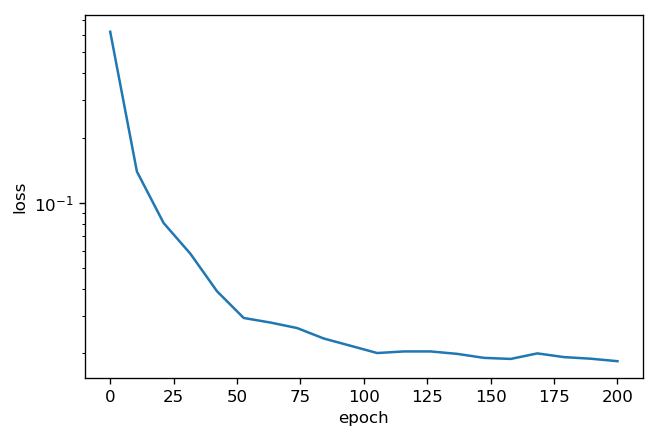

In [24]:
net = get_net(ctx, num_classes=64)
net.hybridize()
train_center(train_data, valid_data, net, ctx, num_epoches, 
      learning_rate, lr_decay, lr_period, 
      momentum, weight_decay, cost_period, 
      print_cost=True)

In [10]:
transform_train = transforms.Compose([
#     transforms.RandomFlipLeftRight(),
#     transforms.RandomFlipTopBottom(),
#     transforms.RandomBrightness(0.1), 
#     transforms.RandomContrast(0.1), 
    transforms.Resize(224), 
    transforms.ToTensor()
])

transform_valid = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

In [11]:
data_dir = './data/FV_TJ/'
batch_size = 8

train_ds = vision.ImageFolderDataset(root=data_dir+'train', flag=1)
valid_ds = vision.ImageFolderDataset(root=data_dir+'valid', flag=1)

train_data = DataLoader(train_ds.transform_first(transform_train), 
                        batch_size, shuffle=False, last_batch='keep')
valid_data = DataLoader(valid_ds.transform_first(transform_valid), 
                        batch_size, shuffle=False, last_batch='keep')

In [12]:
print(len(valid_ds))

print(len(valid_data))
for data, label in valid_data:
    print(data.shape, label.shape)
    print(label.as_in_context(mx.gpu(0)))
    break

640
80
(8, 3, 224, 224) (8,)

[0 0 0 0 0 0 0 0]
<NDArray 8 @gpu(0)>


In [13]:
fingervein_net = get_net(ctx=mx.gpu(0), num_classes=64)
fingervein_net.hybridize()
fingervein_net.load_params('fingervein_weight_centerloss_TJ.txt', ctx=mx.gpu(0))

In [14]:
tr_features = np.zeros((320, 1792))
tr_labels = np.zeros((320))
i = 0
for data, label in train_data:
    data = data.as_in_context(mx.gpu(0))
#             label = label.as_in_context(ctx)
    label = label.astype('float32').as_in_context(mx.gpu(0))
    output, features = fingervein_net(data)
#     print(features.shape)
    features = features.asnumpy()
    label = label.asnumpy()
#     print(features.shape)
    if i+8 > 320:
        tr_features[i:320, :] = features
        tr_labels[i:320] = label
    else:
        tr_features[i:i+8, :] = features
        tr_labels[i:i+8] = label
        i+=8

In [15]:
print(tr_labels[319])

63.0


In [16]:
te_features = np.zeros((640, 1792))
te_labels = np.zeros((640))
i = 0
for data, label in valid_data:
    data = data.as_in_context(mx.gpu(0))
#             label = label.as_in_context(ctx)
    label = label.astype('float32').as_in_context(mx.gpu(0))
    output, features = fingervein_net(data)
#     print(features.shape)
    features = features.asnumpy()
    label = label.asnumpy()
#     print(features.shape)
    if i+8 > 640:
        te_features[i:640, :] = features
        te_labels[i:640] = label
    else:
        te_features[i:i+8, :] = features
        te_labels[i:i+8] = label
        i+=8

In [17]:
print(te_features.shape)

(640, 1792)


In [18]:
def fingervein_dist(f1,f2,w=1):
    if w == 1:
        w = np.ones(f1.shape)
    if len(f1.shape) == len(f2.shape) == 1:
        dist = np.linalg.norm((f1-f2)*w)
    else:
        dist = np.linalg.norm((f1-f2)*w, axis=1)
    return dist

In [19]:
def distance_based_prediction(FingerveinEmbedding, train_Labels, f):
    
    Dists = fingervein_dist(FingerveinEmbedding, f)
    
    i = np.argmin(Dists)
    
    return train_Labels[i]

In [20]:
# test accuracy
nCorrect = 0
ntest = te_features.shape[0]
for i in range(ntest):
    p = distance_based_prediction(tr_features, tr_labels, te_features[i])
    if p == te_labels[i]:
        nCorrect += 1
print('Fingervein recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/ntest))

Fingervein recognition accuracy using purely distance based method: 100.000 %


In [21]:
print(nCorrect)

640


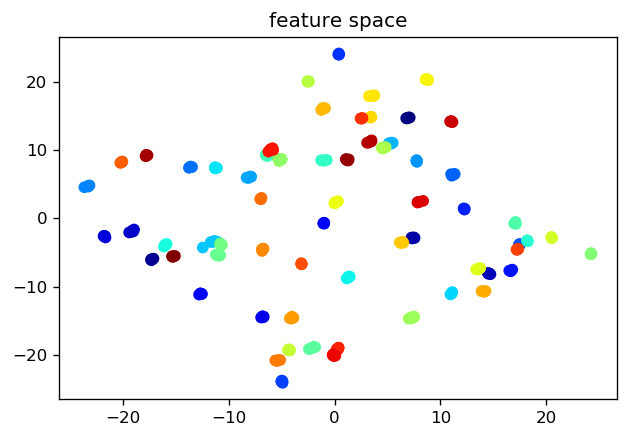

In [22]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(tr_features)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=tr_labels, cmap='jet')
plt.title('feature space')
plt.savefig('feature space -centerloss -TJ.png')

<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:29: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:29: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:29: DeprecationWarning: invalid escape sequence \-
<ipython-input-23-8002f426b3eb>:28: DeprecationWarning: invalid escape sequence \-
  print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
<ipython-input-23-8002f426b3eb>:29: DeprecationWarning: invalid escape sequence \-
  print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))


Cross-class distance = 4.686 +\- 0.349
Same-class distance = 0.327 +\- 0.382


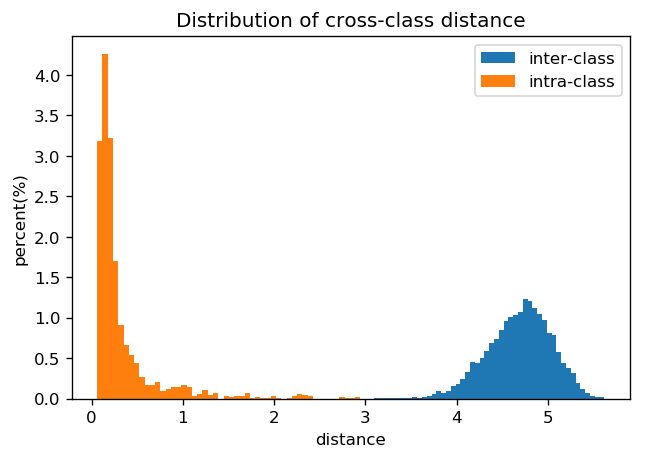

In [23]:
Distances_within_class = []
Distances_among_class = []

ntrain = tr_features.shape[0]
ntest = te_features.shape[0]

for i in range(ntest):
    for j in range(ntrain):
        cur_dist = fingervein_dist(tr_features[j,:],te_features[i,:])
        if te_labels[i] == tr_labels[j]:
            Distances_within_class.append(cur_dist)
        else:
            Distances_among_class.append(cur_dist)
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)


plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'inter-class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'intra-class', normed = True)
plt.title('Distribution of cross-class distance')
plt.xlabel('distance')
plt.ylabel('percent(%)')
plt.legend()
plt.savefig('Distribution of cross-class distance center-loss -TJ.png')

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

EER =  0.0
EER =  0.0
EER =  0.0
EER =  0.0
pct of false positive 0.004 %
pct of false negative 0.000 %
accuracy = 99.996


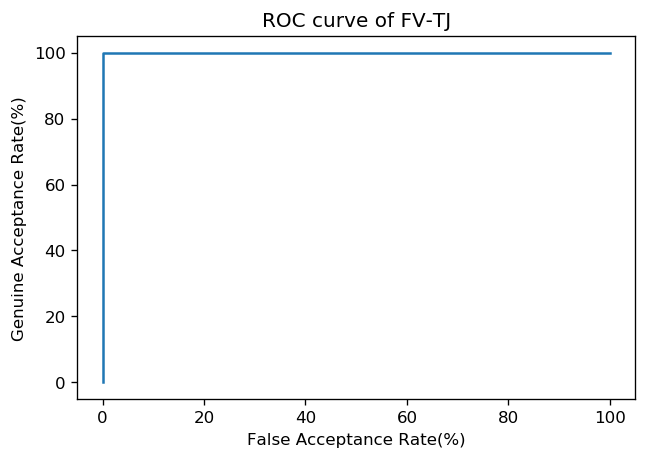

In [24]:
FP = []
FN = []
GAR = []
EER = 0
for threshold in np.arange(0,max(Distances_among_class),0.01):
    FP.append(100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class))
    FN.append(100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))
    if np.abs((100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)) - (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))) < 0.0001:
        print("EER = ", 0.5*(100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)+100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))
GAR = FN
for i, value in enumerate(FN):
    GAR[i] = 100 - FN[i]
                                                                
plt.plot(FP,GAR)
plt.xlabel('False Acceptance Rate(%)')
plt.ylabel('Genuine Acceptance Rate(%)')
plt.title('ROC curve of FV-TJ')
plt.savefig('ROC curve -center-loss -TJ.png')
threshold = 3.1
print('pct of false positive %2.3f %%' % (100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)))
print('pct of false negative %2.3f %%' % (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))

print('accuracy = %2.3f' % (100.0*(np.sum(Distances_among_class>threshold)+np.sum(Distances_within_class<threshold))/(len(Distances_among_class)+len(Distances_within_class))))

In [53]:
a = [1, 2, 3]
for i, value in enumerate(a):
    a[i] -= 3

In [54]:
a

[-2, -1, 0]